In [18]:
from bs4 import BeautifulSoup
from selenium import webdriver
import selenium
from urllib.parse import  urlparse
import time
import lxml
from urllib.request import urlopen
from selenium.webdriver.common.keys import Keys
import numpy as np
import pandas as pd
import re
import pickle
from contextlib import suppress
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate, KFold
from tqdm import tqdm

from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [29]:
plt.rcParams["font.family"] = 'Malgun Gothic'

In [19]:
from collections import Counter

ds_star = pd.read_csv("C:/netsong7/pythonwork/AI/finalproject/data cleaning(final)/shopping_ds.csv")
ds_star

ds_star.drop_duplicates(subset=['type', 'review', 'star'], inplace=True)
ds_star

ds_star["label"] = 0
ds_star

# ds_star.set_index("", inplace=True)
ds_star.loc[ds_star["star"] > 3.5, "label"] = 1
del ds_star["Unnamed: 0"]
ds_star

print(ds_star[ds_star["star"]==5].shape)
print(ds_star[ds_star["star"]==4].shape)
print(ds_star[ds_star["star"]==3].shape)
print(ds_star[ds_star["star"]==2].shape)
print(ds_star[ds_star["star"]==1].shape)
print("===========================================================================")
print(ds_star[ds_star["label"]==1].shape) # star 4, 5점
print(ds_star[ds_star["label"]==0].shape) # star 1, 2, 3점

ds_star_1_dummy, ds_star_1_train = train_test_split(ds_star[ds_star["label"]==1], test_size=5432, random_state = 42)

ds_star_0_train = ds_star[ds_star["label"]==0]
ds_star_balance = pd.concat([ds_star_1_train, ds_star_0_train])
ds_star_balance

(9156, 4)
(6617, 4)
(3265, 4)
(845, 4)
(1322, 4)
(15773, 4)
(5432, 4)


,type,review,star,label
20722,에어닷,그럭저럭 사용하면 함,4,1
16708,홍미노트7,갤럭시만 쓰던 사람인데 세컨폰으로 구입했어요 갤럭시엔 못미치지만 베터리는 갤럭시 압...,4,1
9090,삼성전자 갤럭시S21 5G 256GB [자급제],일단 노트에서 기변하는거라 성능면에서 굉장히 만족했습니다 그리고 디자인 헤이즈 ...,4,1
9289,삼성전자 갤럭시S21 5G 256GB [자급제],좋은제품을 잘 산것같아요 색상도 마음에 들고 기능은 더 사용해봐야할것같고 전화기는 ...,4,1
13616,삼성전자 삼성 갤럭시 워치 액티브2 40mm 알루미늄,사실 쓰다보니 애플워치보다 기능적으로 부족하다고 느껴지기는 하지만기본적으로 스마트 ...,4,1
...,...,...,...,...
23561,미밴드2,쓰기편한데 고무라서 그런지 얼마 안가 다시 사야할거같은 느낌적인느낌이들고 그래도 잘...,1,0
23562,미밴드2,상품평을 많은 기대를 갖고서 구입했으나 전화 수신시 알려만주고 번호는 나타나지 않으...,1,0
23563,미밴드2,금액대비 아주 좋습니다 여러모로 편리하네요 감사합니다 저렴하게 잘 산것 같아요,1,0
23564,미밴드2,일주일 걸림,1,0


In [20]:
print(ds_star_balance.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0   5432
1      1   5432


In [21]:
print(ds_star_balance.isnull().values.any())

False


In [22]:
ds_star_balance['review'] = ds_star_balance['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
ds_star_balance[:5]

C:\Users\not14\anaconda3\envs\tf1\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


,type,review,star,label
20722,에어닷,그럭저럭 사용하면 함,4,1
16708,홍미노트7,갤럭시만 쓰던 사람인데 세컨폰으로 구입했어요 갤럭시엔 못미치지만 베터리는 갤럭시 압...,4,1
9090,삼성전자 갤럭시S21 5G 256GB [자급제],일단 노트에서 기변하는거라 성능면에서 굉장히 만족했습니다 그리고 디자인 헤이즈 ...,4,1
9289,삼성전자 갤럭시S21 5G 256GB [자급제],좋은제품을 잘 산것같아요 색상도 마음에 들고 기능은 더 사용해봐야할것같고 전화기는 ...,4,1
13616,삼성전자 삼성 갤럭시 워치 액티브2 40mm 알루미늄,사실 쓰다보니 애플워치보다 기능적으로 부족하다고 느껴지기는 하지만기본적으로 스마트 ...,4,1


In [23]:
ds_star_balance.drop_duplicates(subset = ['review'], inplace=True) # 중복 제거
ds_star_balance['review'] = ds_star_balance['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
ds_star_balance['review'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
ds_star_balance = ds_star_balance.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(ds_star_balance))

전처리 후 테스트용 샘플의 개수 : 10404


C:\Users\not14\anaconda3\envs\tf1\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [24]:
ds_star_balance['review'] = ds_star_balance['review'].str.replace('^ +', "")
ds_star_balance['review'].replace('', np.nan, inplace=True)
print(ds_star_balance.isnull().sum())

type      0
review    1
star      0
label     0
dtype: int64


C:\Users\not14\anaconda3\envs\tf1\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
C:\Users\not14\anaconda3\envs\tf1\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\not14\anaconda3\envs\tf1\lib\site-packages\pandas\core\series.py:4515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [25]:
ds_star_balance.loc[ds_star_balance.review.isnull()][:5]

,type,review,star,label
21772,에어닷,NaN,2,0


In [26]:
ds_star_balance = ds_star_balance.dropna(how = 'any')
print(len(ds_star_balance))

10403


In [27]:
ds_star_balance.head()

,type,review,star,label
20722,에어닷,그럭저럭 사용하면 함,4,1
16708,홍미노트7,갤럭시만 쓰던 사람인데 세컨폰으로 구입했어요 갤럭시엔 못미치지만 베터리는 갤럭시 압...,4,1
9090,삼성전자 갤럭시S21 5G 256GB [자급제],일단 노트에서 기변하는거라 성능면에서 굉장히 만족했습니다 그리고 디자인 헤이즈 ...,4,1
9289,삼성전자 갤럭시S21 5G 256GB [자급제],좋은제품을 잘 산것같아요 색상도 마음에 들고 기능은 더 사용해봐야할것같고 전화기는 ...,4,1
13616,삼성전자 삼성 갤럭시 워치 액티브2 40mm 알루미늄,사실 쓰다보니 애플워치보다 기능적으로 부족하다고 느껴지기는 하지만기본적으로 스마트 ...,4,1


# 네이버 쇼핑 리뷰 keyword 별 pie plot

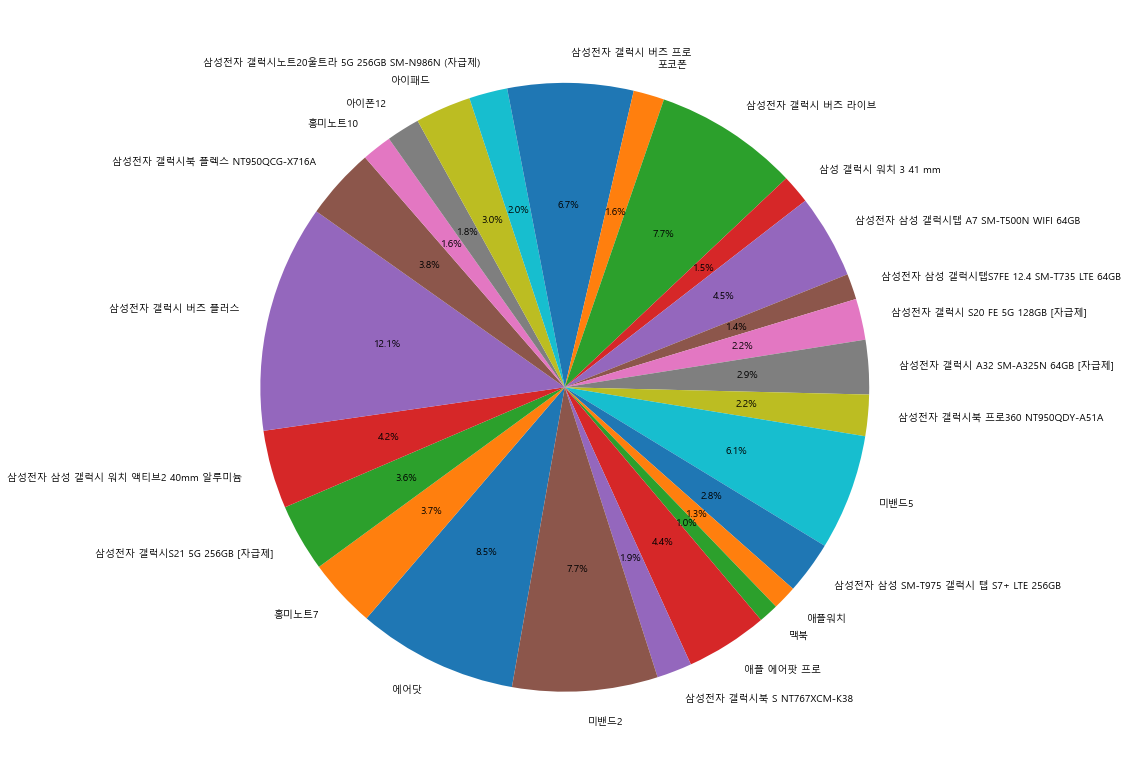

전처리 후 테스트용 샘플의 개수 : 10403


In [37]:
plt.figure(figsize=(16, 14))
ratio = []
labels = []
for word in ds_star_balance["type"].unique():
    ratio.append(len(ds_star_balance[ds_star_balance["type"]==word]))
    labels.append(word)
plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False)
plt.show()
print('전처리 후 테스트용 샘플의 개수 :',sum(ratio))

# 네이버 쇼핑 리뷰 회사 별 전체 댓글 길이 분포

리뷰의 최대 길이 : 4122
리뷰의 평균 길이 : 98.22262808805152


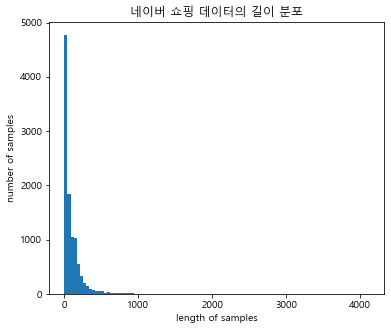

In [45]:
    plt.figure(figsize=(6,5))
    print('리뷰의 최대 길이 :',max(len(l) for l in ds_star_balance["review"]))
    print('리뷰의 평균 길이 :',sum(map(len, ds_star_balance["review"]))/len(ds_star_balance["review"]))
    plt.hist([len(s) for s in ds_star_balance["review"]], bins=100)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.title("네이버 쇼핑 데이터의 길이 분포")
    plt.show()

# 네이버 쇼핑 리뷰 회사 별 pie plot

In [46]:
apple = ['아이폰12', '아이패드', '애플워치', '맥북', '애플 에어팟 프로',]
samsung = ['삼성전자 갤럭시S21 5G 256GB [자급제]','삼성전자 삼성 갤럭시 워치 액티브2 40mm 알루미늄','삼성전자 갤럭시 버즈 플러스',
          '삼성전자 갤럭시북 플렉스 NT950QCG-X716A','삼성전자 갤럭시노트20울트라 5G 256GB SM-N986N (자급제)','삼성전자 갤럭시 버즈 프로',
           '삼성전자 갤럭시 버즈 라이브', '삼성 갤럭시 워치 3 41 mm', '삼성전자 삼성 갤럭시탭 A7 SM-T500N WIFI 64GB',
           '삼성전자 삼성 갤럭시탭S7FE 12.4 SM-T735 LTE 64GB', '삼성전자 갤럭시 S20 FE 5G 128GB [자급제]',
           '삼성전자 갤럭시 A32 SM-A325N 64GB [자급제]', '삼성전자 갤럭시북 프로360 NT950QDY-A51A', '삼성전자 삼성 SM-T975 갤럭시 탭 S7+ LTE 256GB',
          '삼성전자 갤럭시북 S NT767XCM-K38']
xiaomi = ['에어닷','홍미노트7','홍미노트10','포코폰', '미밴드5','미밴드2']
company = []
for word in ds_star_balance["type"]:
    if word in apple:
        company.append("apple")
    if word in samsung:
        company.append("samsung")
    if word in xiaomi:
        company.append("xiaomi")
ds_star_balance["company"] = company

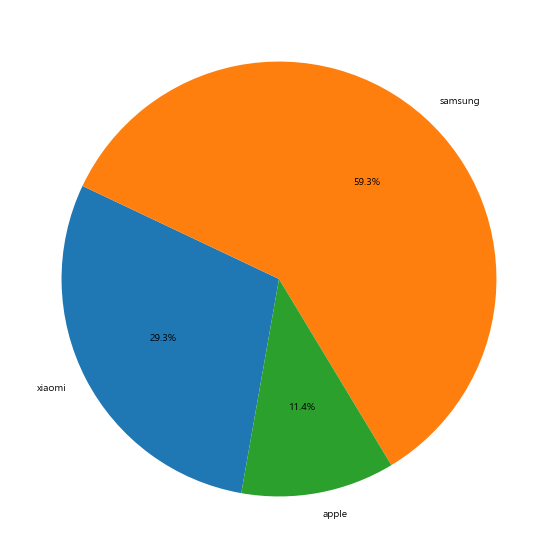

전처리 후 테스트용 샘플의 개수 : 10403


In [47]:
plt.figure(figsize=(12, 10))
ratio = []
labels = []
for word in ds_star_balance["company"].unique():
    ratio.append(len(ds_star_balance[ds_star_balance["company"]==word]))
    labels.append(word)
plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False)
plt.show()
print('전처리 후 테스트용 샘플의 개수 :',sum(ratio))

# 네이버 쇼핑 리뷰 회사 별 전체 댓글 길이 분포

리뷰의 최대 길이 : 3817
리뷰의 평균 길이 : 71.79829172141919


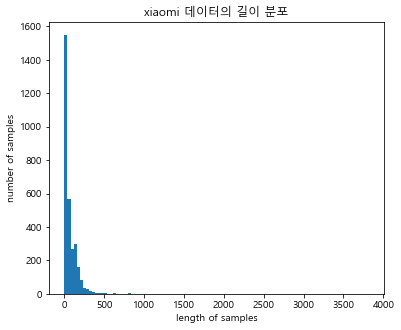

리뷰의 최대 길이 : 4122
리뷰의 평균 길이 : 115.47885269810403


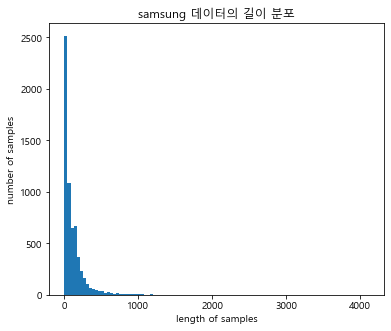

리뷰의 최대 길이 : 1633
리뷰의 평균 길이 : 76.29292929292929


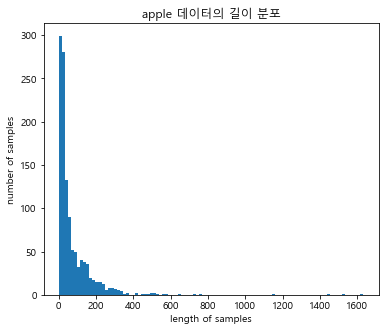

In [48]:

for word in ds_star_balance["company"].unique():
    plt.figure(figsize=(6,5))
    print('리뷰의 최대 길이 :',max(len(l) for l in ds_star_balance[ds_star_balance["company"]==word]["review"]))
    print('리뷰의 평균 길이 :',sum(map(len, ds_star_balance[ds_star_balance["company"]==word]["review"]))/len(ds_star_balance[ds_star_balance["company"]==word]["review"]))
    plt.hist([len(s) for s in ds_star_balance[ds_star_balance["company"]==word]["review"]], bins=100)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.title(word+" "+"데이터의 길이 분포")
    plt.show()

# 네이버 쇼핑 리뷰 keyword 별 전체 댓글 길이 분포

리뷰의 최대 길이 : 678
리뷰의 평균 길이 : 53.97514124293785


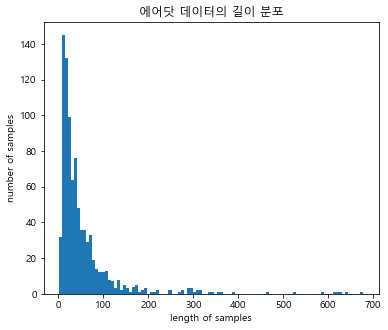

리뷰의 최대 길이 : 1137
리뷰의 평균 길이 : 61.20157068062827


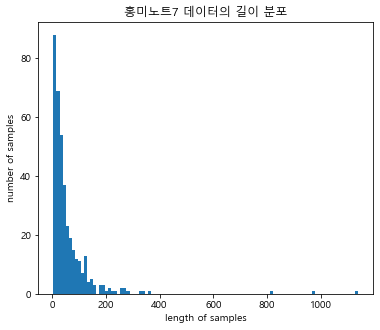

리뷰의 최대 길이 : 1706
리뷰의 평균 길이 : 103.38502673796792


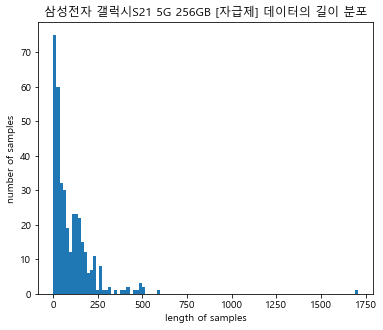

리뷰의 최대 길이 : 447
리뷰의 평균 길이 : 85.07390300230946


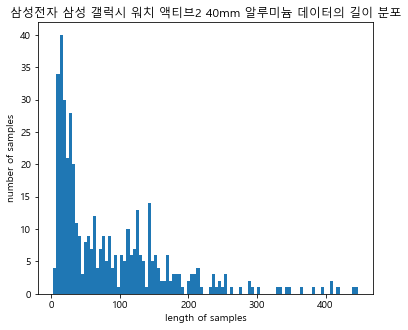

리뷰의 최대 길이 : 1072
리뷰의 평균 길이 : 129.69554848966612


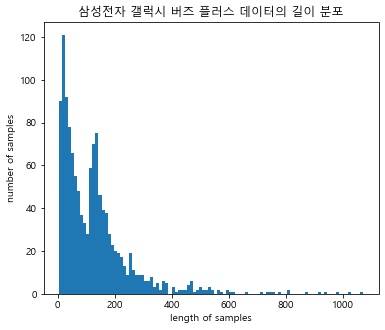

리뷰의 최대 길이 : 1352
리뷰의 평균 길이 : 213.60858585858585


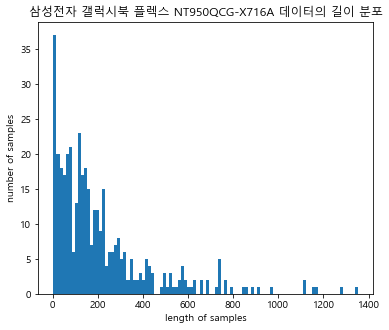

리뷰의 최대 길이 : 456
리뷰의 평균 길이 : 48.406060606060606


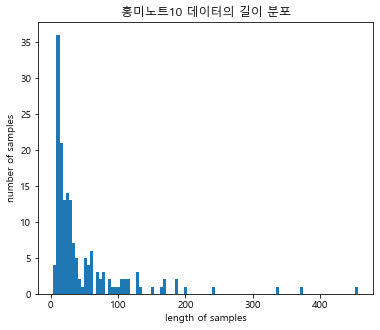

리뷰의 최대 길이 : 411
리뷰의 평균 길이 : 62.25


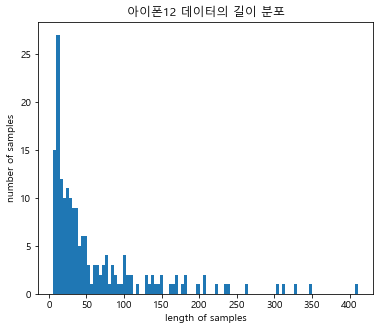

리뷰의 최대 길이 : 1153
리뷰의 평균 길이 : 54.896103896103895


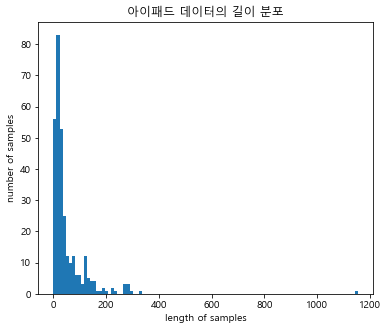

리뷰의 최대 길이 : 457
리뷰의 평균 길이 : 52.344339622641506


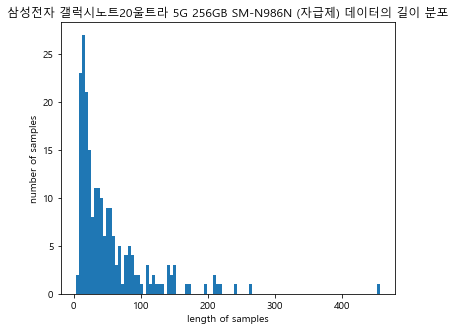

리뷰의 최대 길이 : 4122
리뷰의 평균 길이 : 159.61095100864554


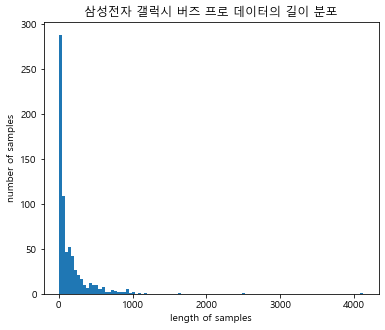

리뷰의 최대 길이 : 806
리뷰의 평균 길이 : 154.69005847953215


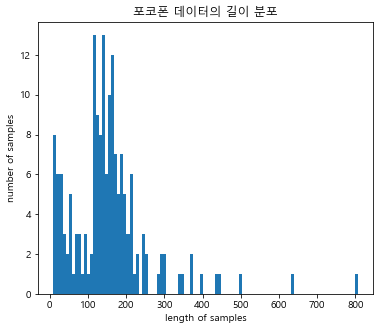

리뷰의 최대 길이 : 1952
리뷰의 평균 길이 : 96.78097622027535


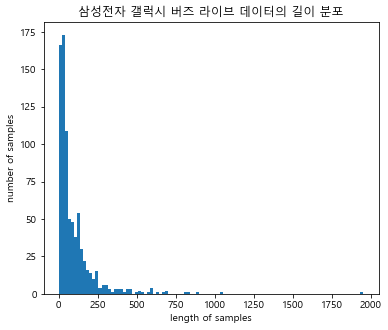

리뷰의 최대 길이 : 286
리뷰의 평균 길이 : 43.63125


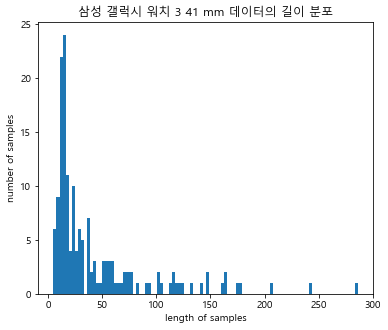

리뷰의 최대 길이 : 716
리뷰의 평균 길이 : 65.1792656587473


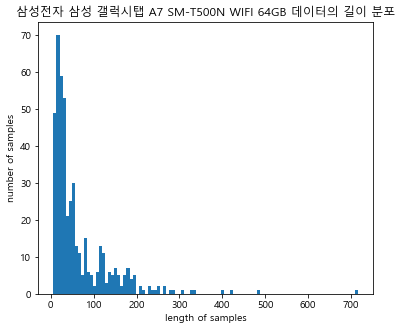

리뷰의 최대 길이 : 670
리뷰의 평균 길이 : 75.95774647887323


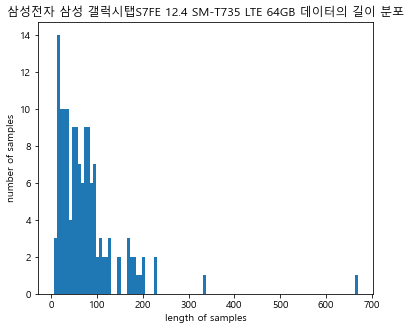

리뷰의 최대 길이 : 537
리뷰의 평균 길이 : 54.819383259911895


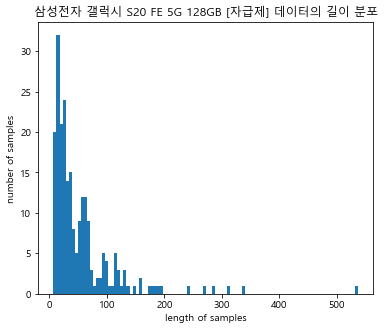

리뷰의 최대 길이 : 407
리뷰의 평균 길이 : 57.166666666666664


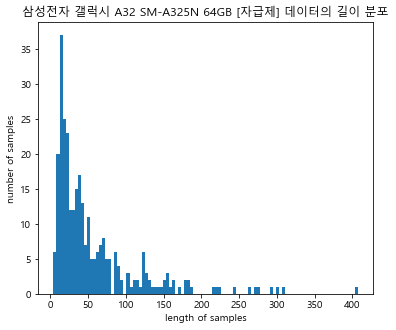

리뷰의 최대 길이 : 1584
리뷰의 평균 길이 : 249.10526315789474


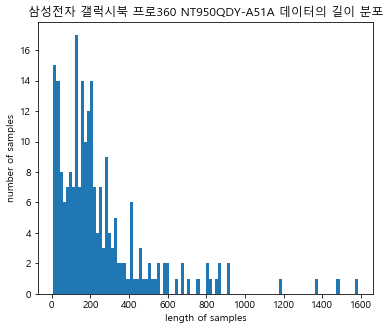

리뷰의 최대 길이 : 3817
리뷰의 평균 길이 : 86.35367762128325


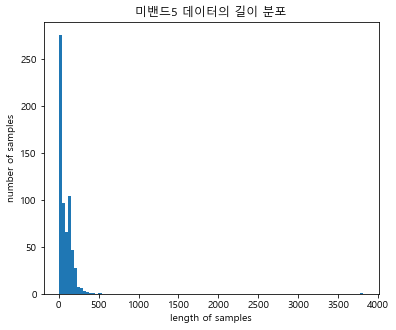

리뷰의 최대 길이 : 1196
리뷰의 평균 길이 : 70.09965635738831


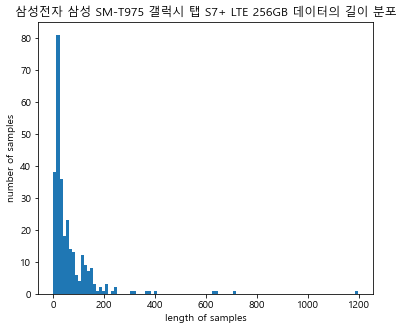

리뷰의 최대 길이 : 534
리뷰의 평균 길이 : 62.38059701492537


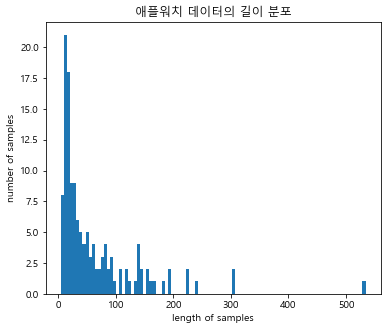

리뷰의 최대 길이 : 483
리뷰의 평균 길이 : 40.80733944954128


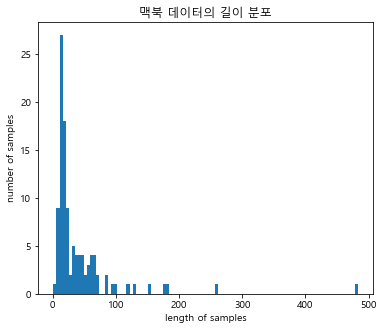

리뷰의 최대 길이 : 1633
리뷰의 평균 길이 : 109.19867549668874


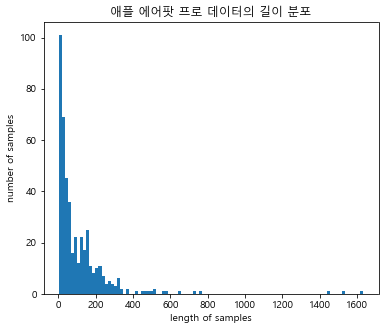

리뷰의 최대 길이 : 1064
리뷰의 평균 길이 : 182.69072164948454


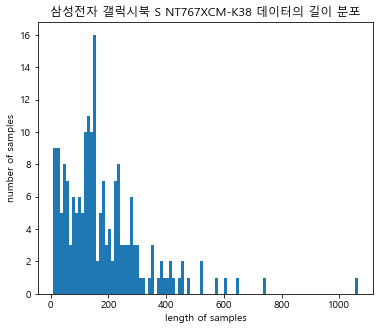

리뷰의 최대 길이 : 701
리뷰의 평균 길이 : 72.05486284289277


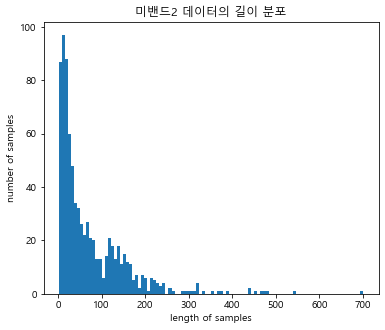

In [32]:
for word in ds_star_balance["type"].unique():
    plt.figure(figsize=(6,5))
    print('리뷰의 최대 길이 :',max(len(l) for l in ds_star_balance[ds_star_balance["type"]==word]["review"]))
    print('리뷰의 평균 길이 :',sum(map(len, ds_star_balance[ds_star_balance["type"]==word]["review"]))/len(ds_star_balance[ds_star_balance["type"]==word]["review"]))
    plt.hist([len(s) for s in ds_star_balance[ds_star_balance["type"]==word]["review"]], bins=100)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.title(word+" "+"데이터의 길이 분포")
    plt.show()

# 네이버 쇼핑 리뷰 긍정, 부정 형태소 랭크

## 불용어 16개

In [10]:
okt = Okt()
stopwords = ['가','게','고','과','네','는','다','도','들','듯','를','에','와','으로',
             '은','을','의','이','인','임','자','잘','좀','지','하다','한']

In [11]:
positve_ds = ds_star_balance[ds_star_balance["label"]==1]
negative_ds = ds_star_balance[ds_star_balance["label"]==0]

In [12]:
positve = []
for sentence in positve_ds['review']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    positve.append(temp_X)
words_positve = np.hstack(positve)
words_positve_count = Counter(words_positve)
print(words_positve_count.most_common(200))

[('좋다', 4340), ('있다', 2885), ('사용', 2094), ('보다', 1978), ('같다', 1910), ('되다', 1847), ('자다', 1835), ('로', 1703), ('너무', 1517), ('구매', 1438), ('이다', 1325), ('없다', 1279), ('배송', 1266), ('것', 1259), ('받다', 1235), ('않다', 1095), ('제품', 1068), ('쓰다', 1051), ('들다', 985), ('에서', 955), ('빠르다', 927), ('생각', 915), ('때', 902), ('하고', 895), ('가격', 869), ('사다', 863), ('기능', 860), ('만족하다', 851), ('오다', 842), ('노트북', 823), ('요', 816), ('안', 796), ('더', 795), ('버즈', 789), ('수', 743), ('제', 713), ('만', 699), ('되어다', 663), ('저', 657), ('갤럭시', 644), ('적', 607), ('폰', 598), ('정말', 582), ('프로', 571), ('많이', 571), ('음질', 546), ('중', 537), ('이어폰', 514), ('정도', 512), ('이라', 506), ('거', 502), ('케이스', 500), ('화면', 494), ('써다', 492), ('고민', 484), ('아니다', 483), ('크다', 482), ('해보다', 474), ('구입', 473), ('주문', 472), ('가볍다', 471), ('디자인', 470), ('성능', 455), ('이쁘다', 452), ('비', 448), ('충전', 442), ('편하다', 441), ('착용', 438), ('저렴하다', 436), ('선물', 433), ('가성', 423), ('아주', 422), ('괜찮다', 420), ('조금', 419), ('색상', 413), ('일'

In [13]:
negative = []
for sentence in negative_ds['review']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    negative.append(temp_X)
words_negative = np.hstack(negative)
words_negative_count = Counter(words_negative)
print(words_negative_count.most_common(200))

[('좋다', 1569), ('있다', 1395), ('받다', 1388), ('되다', 1114), ('제품', 1114), ('안', 1059), ('배송', 981), ('없다', 932), ('보다', 928), ('안되다', 890), ('같다', 836), ('로', 784), ('사용', 755), ('않다', 743), ('센터', 738), ('요', 732), ('자다', 714), ('구매', 706), ('이다', 703), ('에서', 663), ('일', 637), ('오다', 625), ('서비스', 621), ('만', 600), ('너무', 595), ('아니다', 585), ('가다', 570), ('쓰다', 497), ('불량', 496), ('하고', 491), ('사다', 490), ('상품', 484), ('그냥', 474), ('교환', 469), ('것', 464), ('못', 433), ('때', 433), ('가격', 411), ('문제', 399), ('들다', 396), ('생각', 377), ('제', 370), ('그렇다', 366), ('연결', 358), ('더', 356), ('월', 346), ('음질', 339), ('주문', 332), ('모르다', 327), ('보내다', 327), ('충전', 326), ('판매', 321), ('소리', 319), ('버즈', 317), ('서', 315), ('케이스', 312), ('저', 304), ('귀', 304), ('괜찮다', 300), ('삼성', 293), ('빠르다', 290), ('이어폰', 290), ('써다', 289), ('다른', 286), ('분', 278), ('해주다', 276), ('되어다', 271), ('거', 269), ('시간', 267), ('해보다', 260), ('이라', 255), ('주다', 253), ('하', 248), ('한쪽', 247), ('걸리다', 246), ('반품', 243), ('정도', 2

## 불용어 400개

In [14]:
stopwords = pd.read_table("C:/netsong7/pythonwork/AI/stopwords1.txt", encoding='utf-8-sig', header=None,error_bad_lines=False)
stopwords = list(stopwords[0])

b'Skipping line 276: expected 1 fields, saw 2\n'


In [15]:
positve = []
for sentence in positve_ds['review']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    positve.append(temp_X)
words_positve = np.hstack(positve)
words_positve_count = Counter(words_positve)
print(words_positve_count.most_common(200))

[('좋다', 4340), ('있다', 2885), ('사용', 2094), ('보다', 1978), ('되다', 1847), ('자다', 1835), ('너무', 1517), ('구매', 1438), ('이다', 1325), ('없다', 1279), ('배송', 1266), ('받다', 1235), ('않다', 1095), ('제품', 1068), ('쓰다', 1051), ('들다', 985), ('빠르다', 927), ('생각', 915), ('하고', 895), ('가격', 869), ('사다', 863), ('기능', 860), ('만족하다', 851), ('오다', 842), ('노트북', 823), ('요', 816), ('안', 796), ('더', 795), ('버즈', 789), ('수', 743), ('만', 699), ('되어다', 663), ('갤럭시', 644), ('적', 607), ('폰', 598), ('정말', 582), ('프로', 571), ('많이', 571), ('음질', 546), ('중', 537), ('이어폰', 514), ('정도', 512), ('이라', 506), ('거', 502), ('케이스', 500), ('화면', 494), ('써다', 492), ('고민', 484), ('아니다', 483), ('크다', 482), ('해보다', 474), ('구입', 473), ('주문', 472), ('가볍다', 471), ('디자인', 470), ('성능', 455), ('이쁘다', 452), ('비', 448), ('충전', 442), ('편하다', 441), ('착용', 438), ('저렴하다', 436), ('선물', 433), ('가성', 423), ('아주', 422), ('괜찮다', 420), ('색상', 413), ('일', 413), ('소리', 412), ('그렇다', 410), ('처음', 398), ('삼성', 397), ('밴드', 397), ('못', 387), ('많다', 379), ('가

In [17]:
negative = []
for sentence in negative_ds['review']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    negative.append(temp_X)
words_negative = np.hstack(negative)
words_negative_count = Counter(words_negative)
print(words_negative_count.most_common(200))

[('좋다', 1569), ('있다', 1395), ('받다', 1388), ('되다', 1114), ('제품', 1114), ('안', 1059), ('배송', 981), ('없다', 932), ('보다', 928), ('안되다', 890), ('사용', 755), ('않다', 743), ('센터', 738), ('요', 732), ('자다', 714), ('구매', 706), ('이다', 703), ('일', 637), ('오다', 625), ('서비스', 621), ('만', 600), ('너무', 595), ('아니다', 585), ('가다', 570), ('쓰다', 497), ('불량', 496), ('하고', 491), ('사다', 490), ('상품', 484), ('그냥', 474), ('교환', 469), ('못', 433), ('가격', 411), ('문제', 399), ('들다', 396), ('생각', 377), ('그렇다', 366), ('연결', 358), ('더', 356), ('월', 346), ('음질', 339), ('주문', 332), ('모르다', 327), ('보내다', 327), ('충전', 326), ('판매', 321), ('소리', 319), ('버즈', 317), ('서', 315), ('케이스', 312), ('귀', 304), ('괜찮다', 300), ('삼성', 293), ('빠르다', 290), ('이어폰', 290), ('써다', 289), ('분', 278), ('해주다', 276), ('되어다', 271), ('거', 269), ('해보다', 260), ('이라', 255), ('주다', 253), ('한쪽', 247), ('걸리다', 246), ('반품', 243), ('정도', 241), ('처음', 240), ('택배', 240), ('선물', 238), ('기능', 235), ('느리다', 230), ('만족하다', 229), ('알다', 228), ('인데', 225), ('착용', 222),